In [353]:
import pandas as pd  # noqa
import numpy as np  # noqa
from numpy import pi  # noqa
import matplotlib.pyplot as plt  # noqa
from scipy.stats import vonmises, uniform  # noqa
from scipy.optimize import minimize  # noqa
from mpl_toolkits.mplot3d import Axes3D  # noqa
from IPython.display import Image  # noqa
import copy  # noqa

In [2]:
# @title Basic plots of subject estimate average by task conditions

# circular statistics utils
# -------------------
def get_cartesian_to_deg(x: np.ndarray, y: np.ndarray, signed: bool) -> np.ndarray:
    """convert cartesian coordinates to
    angles in degree
    Args:
        x (np.ndarray): x coordinate
        y (np.ndarray): y coordinate
        signed (boolean): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_cartesian_to_deg
            x = np.array([1, 0, -1, 0])
            y = np.array([0, 1, 0, -1])
            degree = get_cartesian_to_deg(x,y,False)
            # Out: array([  0.,  90., 180., 270.])
    Returns:
        np.ndarray: angles in degree
    """
    # convert to radian (ignoring divide by 0 warning)
    with np.errstate(divide="ignore"):
        degree = np.arctan(y / x)

    # convert to degree and adjust based
    # on quadrant
    for ix in range(len(x)):
        if (x[ix] >= 0) and (y[ix] >= 0):
            degree[ix] = degree[ix] * 180 / np.pi
        elif (x[ix] == 0) and (y[ix] == 0):
            degree[ix] = 0
        elif x[ix] < 0:
            degree[ix] = degree[ix] * 180 / np.pi + 180
        elif (x[ix] >= 0) and (y[ix] < 0):
            degree[ix] = degree[ix] * 180 / np.pi + 360

    # if needed, convert signed to unsigned
    if not signed:
        degree[degree < 0] = degree[degree < 0] + 360
    return degree


def get_deg_to_rad(deg: np.array, signed: bool):
    """convert angles in degree to radian
    Args:
        deg (np.array): angles in degree
        signed (bool): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_deg_to_rad
            radians = get_deg_to_rad(np.array([0, 90, 180, 270], True)
            Out: array([ 0., 1.57079633, 3.14159265, -1.57079633])
    Returns:
        np.ndarray: angles in radian
    """
    # get unsigned radians (1:2*pi)
    rad = (deg / 360) * 2 * pi

    # get signed radians(-pi:pi)
    if signed:
        rad[deg > 180] = (deg[deg > 180] - 360) * (2 * pi / 360)
    return rad


def get_polar_to_cartesian(angle: np.ndarray, radius: float, type: str) -> dict:
    """convert angle in degree or radian to cartesian coordinates
    Args:
        angle (np.ndarray): angles in degree or radian
        radius (float): radius
        type (str): "polar" or "radian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_polar_to_cartesian
            degree = np.array([0, 90, 180, 270])
            cartesian = get_polar_to_cartesian(degree, 1, "polar")
            cartesian.keys()

            # Out: dict_keys(['deg', 'rad', 'cart'])

            cartesian["cart"]

            # Out: array([[ 1.,  0.],
            #            [ 0.,  1.],
            #            [-1.,  0.],
            #            [-0., -1.]])
    Returns:
        dict: _description_
    """
    # convert to radian if needed
    theta = dict()
    if type == "polar":
        theta["deg"] = angle
        theta["rad"] = angle * np.pi / 180
    elif type == "radian":
        theta["deg"] = get_deg_to_rad(angle, False)
        theta["rad"] = angle

    # convert to cartesian coordinates
    x = radius * np.cos(theta["rad"])
    y = radius * np.sin(theta["rad"])

    # round to 10e-4
    x = np.round(x, 4)
    y = np.round(y, 4)

    # reshape as (N angles x 2 coord)
    theta["cart"] = np.vstack([x, y]).T
    return theta


def get_circ_weighted_mean_std(angle: np.ndarray, proba: np.ndarray, type: str) -> dict:
    """calculate circular data statistics
    Args:
        angle (np.ndarray): angles in degree or cartesian coordinates
        proba (np.ndarray): each angle's probability of occurrence
        type (str): "polar" or "cartesian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_circ_weighted_mean_std
            degree = np.array([358, 0, 2, 88, 90, 92])
            proba = np.array([1, 1, 1, 1, 1, 1])/6
            output = get_circ_weighted_mean_std(degree, proba, "polar")
            output.keys()
            # Out: dict_keys(['coord_all', 'deg_all', 'coord_mean', 'deg_mean',
            #               'deg_all_for_std', 'deg_mean_for_std', 'deg_var',
            #               'deg_std', 'deg_sem'])
            output["deg_mean"]
            # Out: array([45.])
            output["deg_std"]
            # array([45.02961988])
    Returns:
        (dict): angle summary statistics (mean, std, var, sem)

    Raises:
        ValueError: type is not "polar" or "cartesian"
    """

    angle = angle.copy()

    # if polar, convert to cartesian
    if type == "polar":
        radius = 1
        coord = get_polar_to_cartesian(angle, radius=radius, type="polar")
    elif type == "cartesian":
        coord = angle
    else:
        raise ValueError(""" "type" can either be "polar" or "cartesian" value """)

    # store angles
    data = dict()
    data["coord_all"] = coord["cart"]
    data["deg_all"] = coord["deg"]

    # calculate mean
    # ..............
    proba_for_mean = np.tile(proba[:, None], 2)
    data["coord_mean"] = np.sum(proba_for_mean * data["coord_all"], 0)
    data["coord_mean"] = data["coord_mean"][:, None]
    data["deg_mean"] = get_cartesian_to_deg(
        data["coord_mean"][0],
        data["coord_mean"][1],
        signed=False,
    )

    # calculate std
    # ..............
    n_data = len(data["deg_all"])
    data["deg_all_for_std"] = data["deg_all"]
    data["deg_mean_for_std"] = np.tile(data["deg_mean"], n_data)

    # apply corrections
    # when 0 <= mean <= 180
    if data["deg_mean"] + 180 <= 360:
        for ix in range(n_data):
            if data["deg_all"][ix] >= data["deg_mean"] + 180:
                data["deg_all_for_std"][ix] = data["deg_all"][ix] - 360
    else:
        # when 180 <= mean <= 360
        for ix in range(n_data):
            if data["deg_all"][ix] <= data["deg_mean"] - 180:
                data["deg_mean_for_std"][ix] = data["deg_mean"] - 360

    # calculate variance, standard deviation and
    # standard error to the mean
    data["deg_var"] = np.array(
        [sum(proba * (data["deg_all_for_std"] - data["deg_mean_for_std"]) ** 2)]
    )
    data["deg_std"] = np.sqrt(data["deg_var"])
    data["deg_sem"] = data["deg_std"] / np.sqrt(n_data)
    return data


def get_signed_angle(origin: np.ndarray, destination: np.ndarray, type: str):
    """get the signed angle difference between origin and destination angles
    Args:
        origin (np.ndarray): origin angle
        destination (np.ndarray): destination angle
        type (str): angle type ("polar", "radian", "cartesian")
    Usage:
        .. code-block:: python
            angle = get_signed_angle(90, 45, 'polar')

            # Out: array([45.])

            angle = get_signed_angle(90, 45, 'radian')
            # Out: array([58.3103779])
            origin = np.array([[0, 1]])
            destination = np.array([[1, 0]])
            angle = get_signed_angle(origin, destination, "cartesian")

            # Out: array([90.])
    Returns:
        (np.ndarray): signed angle differences
    """

    # convert to cartesian coordinates
    if type == "polar" or type == "radian":
        origin_dict = get_polar_to_cartesian(origin, radius=1, type=type)
        destination_dict = get_polar_to_cartesian(destination, radius=1, type=type)
    elif type == "cartesian":
        origin_dict = dict()
        destination_dict = dict()
        origin_dict["cart"] = origin
        destination_dict["cart"] = destination

    # get coordinates
    xV1 = origin_dict["cart"][:, 0]
    yV1 = origin_dict["cart"][:, 1]
    xV2 = destination_dict["cart"][:, 0]
    yV2 = destination_dict["cart"][:, 1]

    # Calculate the angle separating the
    # two vectors in degrees
    angle = -(180 / np.pi) * np.arctan2(xV1 * yV2 - yV1 * xV2, xV1 * xV2 + yV1 * yV2)
    return angle


def get_combination_set(database: np.ndarray):
    """get the set of row combinations

    Args:
        database (np.ndarray): an N-D array

    Returns:
        (np.ndarray, np.ndarray, np.ndarray): `combs` is the set
        of combinations, `b` are the row indices for each combination
        in database, `c` are the rows indices for each combination in
        combs.
    """
    combs, ia, ic = np.unique(
        database,
        return_index=True,
        return_inverse=True,
        axis=0,
    )
    return (combs, ia, ic)


def get_data_stats(data: pd.Series, output: dict):
    """calculate data statistics

    Args:
        data (pd.Series): stimulus feature estimates
        output (dict): ::

            'PestimateGivenModel': estimate probabilities
            'map': max-a-posteriori percepts
            'conditions': task conditions

    Returns:
        (dict): returns data mean and std to output
    """
    # get conditions
    cond = output["conditions"]

    # initialise statistics
    data_mean = []
    data_std = []

    # get set of conditions
    cond_set, ix, _ = get_combination_set(cond)

    # record stats by condition
    for c_i in range(len(cond_set)):
        # find condition's instances
        loc_1 = cond[:, 0] == cond_set[c_i, 0]
        loc_2 = cond[:, 1] == cond_set[c_i, 1]
        loc_3 = cond[:, 2] == cond_set[c_i, 2]

        # get associated data
        data_c_i = data.values[loc_1 & loc_2 & loc_3]

        # set each instance with equal probability
        trial_proba = np.tile(1 / len(data_c_i), len(data_c_i))

        # get statistics
        stats = get_circ_weighted_mean_std(
            data_c_i,
            trial_proba,
            type="polar",
        )

        # record statistics
        data_mean.append(stats["deg_mean"])
        data_std.append(stats["deg_std"])

    # record statistics
    output["data_mean"] = np.array(data_mean)
    output["data_std"] = np.array(data_std)

    # record their condition
    output["conditions"] = cond_set
    return output


# Visualization utils
# -------------------
def plot_mean(
    data_mean: np.ndarray,
    data_std: np.ndarray,
    condition: np.ndarray,
    prior_mode: float,
    centering: bool,
):
    """plot data and prediction mean and std
    for three conditions (x-axis, colors and panels)
    Args:
        data_mean (np.ndarray): data mean by condition
        data_std (np.ndarray): data std by condition
        prediction_mean (np.ndarray): prediction mean by condition
        prediction_std (np.ndarray): prediction std by condition
        condition (np.ndarray): associated conditions
        prior_mode (float): the mode of the prior
        centering (bool): center x-axis or not
    Returns:
        _type_: _description_
    """
    # get condition levels
    levels_1 = np.flip(np.unique(condition[:, 0]))
    levels_2 = np.flip(np.unique(condition[:, 1]))  # sort in decreasing order
    levels_3 = np.unique(condition[:, 2])

    # set x_tick
    x_tick_centered = get_signed_angle(levels_1, prior_mode, "polar")
    x_tick_centered[x_tick_centered == -180] = 180
    i_sort = np.argsort(x_tick_centered)
    x_tick_centered = x_tick_centered[i_sort]
    y_tick_centered = x_tick_centered

    # set colors
    levels_2_color = [
        [0.5, 0, 0],
        [1, 0.2, 0],
        [1, 0.6, 0],
        [0.75, 0.75, 0],
    ]

    plt.figure(figsize=(10, 3))

    # loop over conditions and plot data
    # and prediction stats
    for level2_ix in range(len(levels_2)):
        # set condition 2 in column panels
        plt.subplot(1, len(levels_2), level2_ix + 1)

        # set condition 3 within panels
        for level1_ix in range(len(levels_1)):
            # find condition's instances
            loc_lev1 = condition[:, 0] == levels_1[level1_ix]
            loc_lev2 = condition[:, 1] == levels_2[level2_ix]
            loc_condition = loc_lev2 & loc_lev1

            # center to prior mode
            x_centered = condition[:, 2][loc_condition]
            if centering:
                x_centered = np.round(
                    get_signed_angle(
                        x_centered,
                        prior_mode,
                        "polar",
                    )
                )

            x_centered[x_centered == -180] = 180

            # make 2-D array
            x_centered = x_centered[:, None]

            # sort data stats
            y_data_centered = data_mean[loc_condition]
            y_data_std_centered = data_std[loc_condition]

            # sort all
            i_sort = np.argsort(x_centered.squeeze())
            x_centered = x_centered[i_sort]
            y_data_centered = y_data_centered[i_sort]
            y_data_std_centered = y_data_std_centered[i_sort]

            # To plot estimates mean against circular stimulus
            # feature on a linear space, the raw stimulus feature and
            # estimates mean are normalized to vectorial angles from
            # the prior mode and x and y axes are centered at zero
            # (normalized prior mode) via a circular shift. Rotation
            # angles were then labelled according to their raw values
            # on the circle (e.g., 0, is labelled 225). A mean estimate
            # of 33 degree was calculated for 55 degree which is very far
            # from stimulus feature on the linear space but actually close
            # to stimulus feature on the circular space. We got rid of
            # this visual artifact by expressing both 55 and 33 as the
            # counterclockwise distance to prior mode (e.g., for a prior
            # mode 225 55 becomes 190 instead of 170 and 33 becomes 168).
            # Note that the maximum vectorial angle is >180.
            if (level2_ix == 3) & (180 not in x_centered):
                # move point at -170? distance to prior at 190? (positive
                # side) and convert values at x=-170? to positive distance
                # relative to prior to improve visualization
                posNeg170 = x_centered == -170
                x_centered[posNeg170] = prior_mode - 170 + 360 - prior_mode
                x_centered[x_centered == 180] = -180
                y_data_centered[posNeg170] = (
                    prior_mode - abs(y_data_centered[posNeg170]) + 360 - prior_mode
                )

                # sort x-axis
                i_sort = np.argsort(x_centered)
                x_centered = x_centered[i_sort]

                # sort y-axis
                y_data_centered = y_data_centered[i_sort]

                # set ticks
                x_tick_centered = x_centered

            # plot data stats
            plt.errorbar(
                x_centered.squeeze(),
                y_data_centered.squeeze(),
                yerr=y_data_std_centered.squeeze(),
                marker="o",
                markersize=7,
                markeredgecolor="w",
                linestyle="None",
                linewidth=1,
                color=levels_2_color[level1_ix],
                ecolor=levels_2_color[level1_ix],
            )
            plt.ylim([-0, 360])
            plt.hlines(prior_mode, -180, 180, linestyle=":")
            plt.xticks([-160, -80, 0, 80, 160], [-160, -80, 0, 80, 160])
            plt.yticks([67, 147, 227, 307, 387], [-160, -80, 0, 80, 160])
            plt.xlabel(
                "Motion direction distance"
                "\n"
                "relative to the prior mean"
                "\n"
                "(deg)"
            )
            if level2_ix == 0:
                plt.ylabel(
                    "Mean estimates distance"
                    "\n"
                    "relative to the prior mean"
                    "\n"
                    "(deg)"
                )
        plt.title(f"{int(levels_2[level2_ix]*100)}% coherence", fontsize=12)
    plt.show()
    return None

In [3]:
# @title Data loading
data = pd.read_csv("data01_direction4priors.csv")
data = pd.DataFrame(data)

In [4]:
data["motion_direction_rad"] = get_deg_to_rad(data["motion_direction"], False)

# Calculate degree and rad subject estimate angles
data["estimates_deg"] = np.round(
    get_cartesian_to_deg(data["estimate_x"], data["estimate_y"], False)
)
data["estimates_rad"] = get_deg_to_rad(data["estimates_deg"], False)

### Clean data


In [5]:
# Remove rows with nan estimates_deg
data = data.dropna(subset=["estimates_deg"])

### Helper functions


In [6]:
def my_gaussian(x_points, mu, sigma):
    """
    Returns a Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`

    Args :
      x_points (numpy arrays of floats)- points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - std of the gaussian

    Returns:
      Gaussian evaluated at `x`
    """
    p = np.exp(-((x_points - mu) ** 2) / (2 * sigma**2))
    return p / sum(p)

First, we try to recreate a simple part of the paper as a sanity check.
The paper plots the distribution of subject estimates for different values of motion direction.
Since this is not practical for every single value of motion direction, the authors split the directions into 10 degree bins so that there are 36 total motion direction groups.

The paper plots subject estimate distribution for each motion direction group. It does this for each subject, and then averages across subjects to obtain the final estimate distributions. That is what we re-create below.


### 80 degrees prior std and 6% motion coherence


In [8]:
def generate_histograms(data, motion_coherence, prior_std):
    # Split estimated angles into 10 degree bins for a total of 36 bins
    bins = np.linspace(0, 360, 37)

    filtered_data = data[
        (data["motion_coherence"] == motion_coherence)
        & (data["prior_std"] == prior_std)
    ]

    bin_histograms = []
    for i in range(len(bins) - 1):
        subject_data = filtered_data[
            (filtered_data["motion_direction"] >= bins[i])
            & (filtered_data["motion_direction"] < bins[i + 1])
        ]
        # Get distribution for each subject and then average over subjects
        all_histograms = []

        # Group by subject and compute histogram for each subject
        grouped = subject_data.groupby("subject_id")

        for subject_id, group in grouped:
            adjusted = group["estimates_deg"] - 225
            hist, _ = np.histogram(adjusted, bins=50, density=True, range=(-160, 160))
            hist = np.nan_to_num(hist)
            all_histograms.append(hist)

        bin_histograms.append(np.mean(all_histograms, axis=0))

    return bin_histograms

`binned_histograms` contains the histogram of estimate distributions for each 10 degree bins, averaged across subjects.


In [9]:
binned_histograms = generate_histograms(data, 0.06, 80)

/Users/kimyoungjin/Desktop/neuromatch/venv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Now we plot these histograms.


In [10]:
def plot_binned_histograms(binned_histograms):
    bins = np.linspace(0, 360, 37)

    # For each interval, find all the motion directions that fall within that interval
    # and plot the histogram of estimated angles
    fig, axs = plt.subplots(
        len(bins) - 1,
        1,
        figsize=(10, 50),
        sharex=True,
        sharey=True,
    )
    for i in range(len(bins) - 1):
        ax = axs[i]
        bin_edges = np.linspace(-160, 160, 51)  # 50 bins, so 51 edges
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.plot(bin_centers, binned_histograms[i])
        ax.set_yticklabels([])

    fig.text(
        0.5,
        0.04,
        "Estimate directions relative to the prior mean (in degrees)",
        ha="center",
        va="center",
        fontsize=16,
    )
    fig.text(
        0.06,
        0.5,
        "Probability",
        ha="center",
        va="center",
        rotation="vertical",
        fontsize=16,
    )
    # Adjust subplot parameters to reduce the margin
    plt.subplots_adjust(
        left=0.1,  # adjust the left margin
        right=0.9,  # adjust the right margin
        top=0.95,  # adjust the top margin
        bottom=0.05,  # adjust the bottom margin
        hspace=0,  # adjust the vertical space between subplots
    )

    plt.show()

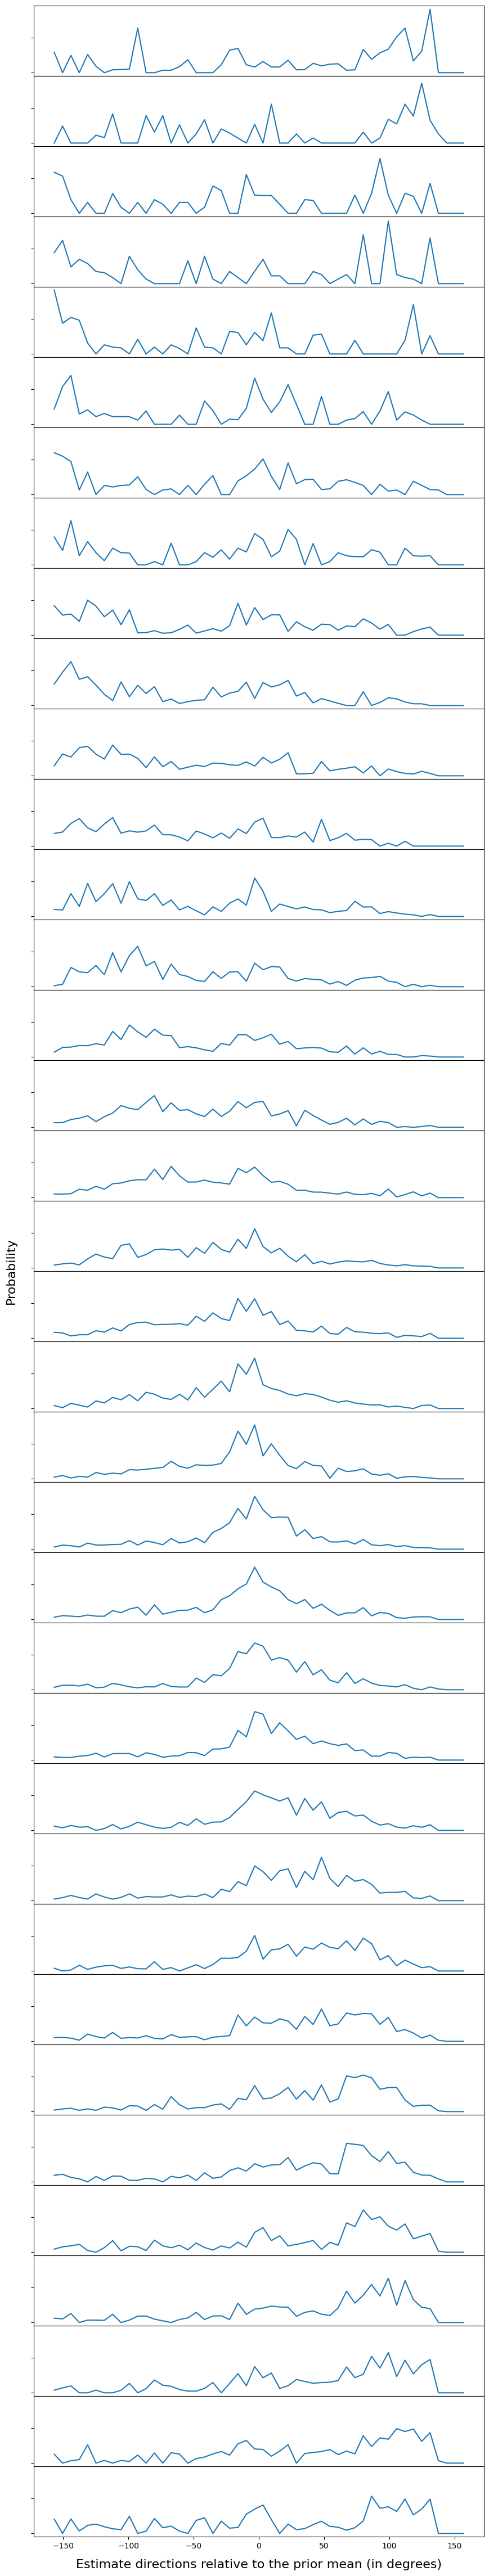

In [11]:
plot_binned_histograms(binned_histograms)

We can see that the "bi-modality" mentioned by the paper can be seen.
"Subject estimate distributions were characterized by two peaks: one at the motion direction and one at the prior mean."

We can see that there is indeed roughly two peaks in the distributions above - one at 0 (prior mean) and one near the motion direction.


### Basic Bayesian


We now create the Basic Bayesian model and try training it on a subset of the data: 80 degrees prior std and 6% motion coherence.

Then we plot the trained Basic Bayesian estimate distributions together with the subject estimates to see how well they fit together. This will enable us to reproduce the leftmost diagram in Figure 4 of the paper:


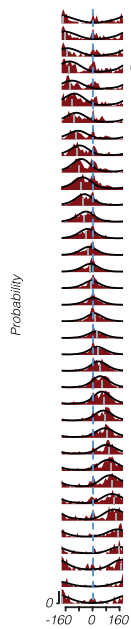

In [292]:
Image("figure_4_left.png")

In [361]:
class BayesianModel:
    def __init__(self, kappa_e, kappa_prior, kappa_m=5, p_r=0.005):
        self.kappa_e = kappa_e
        self.kappa_prior = kappa_prior

        self.kappa_m = kappa_m
        self.p_r = p_r

        # Mean is 225 in radians
        self.prior_mean = np.deg2rad(225)
        self.theta_range = np.linspace(0, 2 * pi, 360, endpoint=False)

    def output(self, theta_true, prior=None):
        # Theta_true should be in radians

        # Initialize sensory evidence distribution
        # sensory_evidence_distribution = vonmises.pdf(theta_range, kappa=self.kappa_e, loc=theta_true)

        # Make a draw from the sensory evidence distribution to get theta_ei
        theta_ei = vonmises.rvs(kappa=self.kappa_e, loc=theta_true, size=1)

        # Sensory likelihood distribution centered on theta_ei
        self.likelihood_distribution = vonmises.pdf(
            self.theta_range, kappa=self.kappa_e, loc=theta_ei
        )

        # Prior distribution
        self.prior_distribution = vonmises.pdf(
            self.theta_range, kappa=self.kappa_prior, loc=self.prior_mean
        )

        if prior is not None:
            self.prior_distribution = prior

        unnormalized_posterior = self.likelihood_distribution * self.prior_distribution

        # Normalize the posterior
        self.posterior_distribution = unnormalized_posterior / np.trapz(
            unnormalized_posterior, self.theta_range
        )

        # Get the mode of the posterior distribution
        mode = self.theta_range[np.argmax(self.posterior_distribution)]

        # This is the bayesian model estimate
        return mode

    def neg_log_likelihood(self, params, data):
        if len(params) > 0:
            (
                self.kappa_e,
                self.kappa_prior,
            ) = params
        log_prob = 0
        # for theta_true_rad, theta_est_rad, theta_est_deg, coherence, prior_std in data:
        for index, row in data.iterrows():
            (
                motion_direction,
                theta_est_rad,
                theta_est_deg,
                motion_coherence,
                prior_std,
            ) = row
            user_percept = self.output(motion_direction)

            # theta_est is radian
            # est_bin = int(np.floor(np.rad2deg(theta_est)))
            log_prob += np.log(
                self.posterior_distribution[int(theta_est_deg) - 1] + 1e-10
            )  # Add small constant to avoid log(0)

        return -log_prob  # Return negative log-likelihood for minimization

    def fit(self, data):
        # Initial parameter guesses
        initial_params = [1.0, 2.0]

        bounds = [(0, None), (0, None)]

        # Fit the model using maximum likelihood estimation
        result = minimize(
            self.neg_log_likelihood,
            initial_params,
            args=(data,),
            method="Nelder-Mead",
            bounds=bounds,
        )

        (
            self.kappa_e,
            self.kappa_prior,
        ) = result.x
        return result.x

    def plot_all(self):
        # Plot likelihoods, prior and posterior on a single plot
        fig, ax = plt.subplots(figsize=(12, 6))

        ax.plot(
            np.rad2deg(self.theta_range),
            self.sensory_likelihood_distribution,
            label="Sensory likelihood",
        )
        ax.plot(np.rad2deg(self.theta_range), self.prior_distribution, label="Prior")
        ax.plot(
            np.rad2deg(self.theta_range), self.posterior_distribution, label="Posterior"
        )

        ax.set_xlabel("Theta (degrees)")
        ax.set_ylabel("Probability")

        ax.legend()
        plt.show()

Intuitively, what do the inputs to the Bayesian model mean?
What do kappa_e and kappa_prior mean, and how should they affect any estimate distributions created by the Bayesian model?

Ok, so kappa_e has multiple roles.

1. kappa_e decides the concentration of the sensory evidence distribution. Basically, given a true theta, how concentrated is the distribution of user sensory perception theta_e around that true theta?
2. kappa_e is also used for the sensory likelihood distribution centered around a single draw from the sensory evidence distribution (theta_ei). This distribution tells us how likely the perceived theta_ei is given different values of theta_true.

kappa_prior

1. kappa-prior decides the concentration of the prior distribution. We kind of assume that the subject immediately knows the prior std of the block he is in. Given that, we probably need to make the kappa_prior match the prior std we are training our data for.

How should we "eyeball" the fit of the data to the bayesian estimates?
I guess we can try plotting a full grid of different kappa values against the data, see a whole grid, and choose kappa based on the best fit.


Filter data for motion coherence 0.06 and prior std 80.


In [304]:
data_subset = data[(data["motion_coherence"] == 0.06) & (data["prior_std"] == 80)]

In [305]:
len(data_subset)

16663

Let's try plotting Bayesian and subject estimates for 0 to 10 degrees motion coherence.


In [307]:
model = BayesianModel(
    kappa_e=1,
    kappa_prior=0.05,
)

In [308]:
data_slice = data_subset[
    (data["motion_direction"] >= 0) & (data["motion_direction"] < 10)
]

/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/3683880963.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_slice = data_subset[


#### Bayesian estimates with smoothing


/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/1169249977.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  self.posterior_distribution = unnormalized_posterior / np.trapz(
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/1387563850.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  smoothed_hist = smoothed_hist / np.trapz(smoothed_hist, bin_centers)


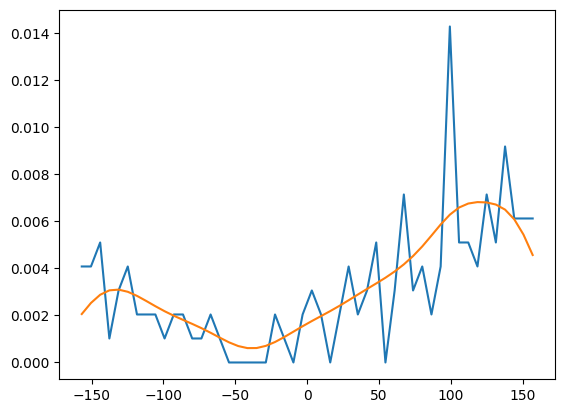

In [309]:
estimates = []
for motion_direction in data_slice["motion_direction"]:
    estimate = model.output(np.deg2rad(motion_direction))
    estimates.append(estimate)

# Convert estimates to degrees
estimates_deg = np.rad2deg(estimates)
estimates_deg = estimates_deg - 225

estimates_deg = (estimates_deg + 160) % 360 - 160

# bin_edges = np.linspace(0, 360, 51)  # 50 bins, 51 edges
bin_edges = np.linspace(-160, 160, 51)  # 50 bins, 51 edges

hist, _ = np.histogram(estimates_deg, bins=bin_edges, density=True)
hist = np.nan_to_num(hist)

# Calculate bin centers for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

motor_noise = vonmises.pdf(np.deg2rad(bin_centers), 10, loc=0)
# Perform circular convolution
smoothed_hist = fftconvolve(hist, motor_noise, mode="same")
smoothed_hist = smoothed_hist / np.trapz(smoothed_hist, bin_centers)

# Ensure hist is normalized
plt.plot(bin_centers, hist)
plt.plot(bin_centers, smoothed_hist)

#### Subject estimates with smoothing


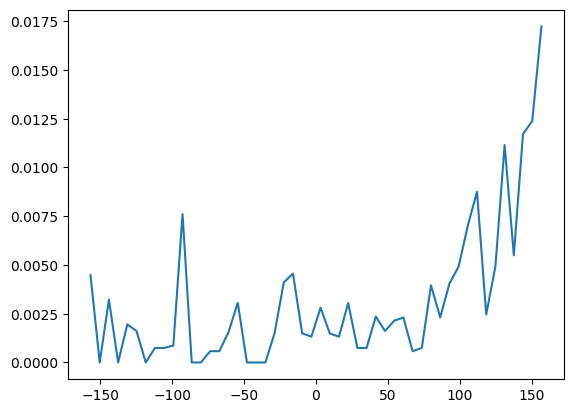

In [310]:
all_histograms = []
grouped = data_slice.groupby("subject_id")

# bin_edges = np.linspace(0, 360, 51)  # 50 bins, 51 edges
bin_edges = np.linspace(-160, 160, 51)  # 50 bins, 51 edges
for subject_id, group in grouped:
    adjusted = group["estimates_deg"]
    adjusted = adjusted - 225
    adjusted = (adjusted + 160) % 360 - 160

    hist, _ = np.histogram(adjusted, bins=bin_edges, density=True)
    hist = np.nan_to_num(hist)
    all_histograms.append(hist)

subject_est_hist = np.mean(all_histograms, axis=0)

# Calculate bin centers for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, subject_est_hist)

We can see that the shapes are roughly similar. We now try plotting Bayesian and subject estimates for all values of motion direction (separated into 10 degree bins).


In [311]:
# Subject estimates are averaged over subjects
def generate_bin_pairs(data, model):
    # Split estimated angles into 10 degree bins for a total of 36 bins
    bins = np.linspace(0, 360, 37)
    bin_edges = np.linspace(-160, 160, 51)  # 50 bins, 51 edges

    bin_histograms = []
    for i in range(len(bins) - 1):
        subject_data = data[
            (data["motion_direction"] >= bins[i])
            & (data["motion_direction"] < bins[i + 1])
        ]

        # Generate Bayesian estimates for each motion direction
        estimates = []
        for motion_direction in subject_data["motion_direction"]:
            estimate = model.output(np.deg2rad(motion_direction))
            estimates.append(estimate)

        # Convert estimates to degrees
        estimates_deg = np.rad2deg(estimates)
        estimates_deg = estimates_deg - 225
        estimates_deg = (estimates_deg + 160) % 360 - 160

        hist, _ = np.histogram(estimates_deg, bins=bin_edges, density=True)
        bayes_hist = np.nan_to_num(hist)

        # Group by subject and compute histogram for each subject
        all_histograms = []
        grouped = subject_data.groupby("subject_id")
        for subject_id, group in grouped:
            adjusted = group["estimates_deg"]
            adjusted = adjusted - 225
            adjusted = (adjusted + 160) % 360 - 160
            hist, _ = np.histogram(adjusted, bins=bin_edges, density=True)
            hist = np.nan_to_num(hist)
            all_histograms.append(hist)

        subject_est_hist = np.mean(all_histograms, axis=0)

        # bin_histograms.append((smoothed_hist, subject_est_hist))
        bin_histograms.append((bayes_hist, subject_est_hist))

    return bin_histograms

In [315]:
def plot_binned_histograms(binned_histograms, noise_kappa=1):
    bins = np.linspace(0, 360, 37)

    # For each interval, find all the motion directions that fall within that interval
    # and plot the histogram of estimated angles
    fig, axs = plt.subplots(
        len(bins) - 1,
        1,
        figsize=(8, 50),
        sharex=True,
        sharey=True,
    )
    for i in range(len(bins) - 1):
        ax = axs[i]
        bin_edges = np.linspace(-160, 160, 51)  # 50 bins, so 51 edges
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bayesian_hist = binned_histograms[i][0]
        subject_hist = binned_histograms[i][1]

        motor_noise = vonmises.pdf(np.deg2rad(bin_centers), noise_kappa, loc=0)
        # Perform circular convolution
        smoothed_hist = fftconvolve(bayesian_hist, motor_noise, mode="same")
        smoothed_hist = smoothed_hist / np.trapz(smoothed_hist, bin_centers)

        ax.plot(bin_centers, smoothed_hist, label="Bayesian")
        ax.plot(bin_centers, subject_hist, label="Subject")
        ax.set_yticklabels([])

    fig.text(
        0.5,
        0.04,
        "Estimate directions relative to the prior mean (in degrees)",
        ha="center",
        va="center",
        fontsize=16,
    )
    fig.text(
        0.06,
        0.5,
        "Probability",
        ha="center",
        va="center",
        rotation="vertical",
        fontsize=16,
    )
    # Adjust subplot parameters to reduce the margin
    plt.subplots_adjust(
        left=0.1,  # adjust the left margin
        right=0.9,  # adjust the right margin
        top=0.95,  # adjust the top margin
        bottom=0.05,  # adjust the bottom margin
        hspace=0,  # adjust the vertical space between subplots
    )

    plt.show()

In [313]:
model = BayesianModel(
    kappa_e=1,
    kappa_prior=0.05,
)
bin_pairs = generate_bin_pairs(data_subset, model)

/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/1169249977.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  self.posterior_distribution = unnormalized_posterior / np.trapz(


/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/2864535710.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  smoothed_hist = smoothed_hist / np.trapz(smoothed_hist, bin_centers)
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/2864535710.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  smoothed_hist = smoothed_hist / np.trapz(smoothed_hist, bin_centers)
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/2864535710.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  smoothed_hist = smoothed_hist / np.trapz(smoothed_hist, bin_centers)
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/2864535710.py:23: DeprecationWarning: `trapz` is deprecated. Use `tra

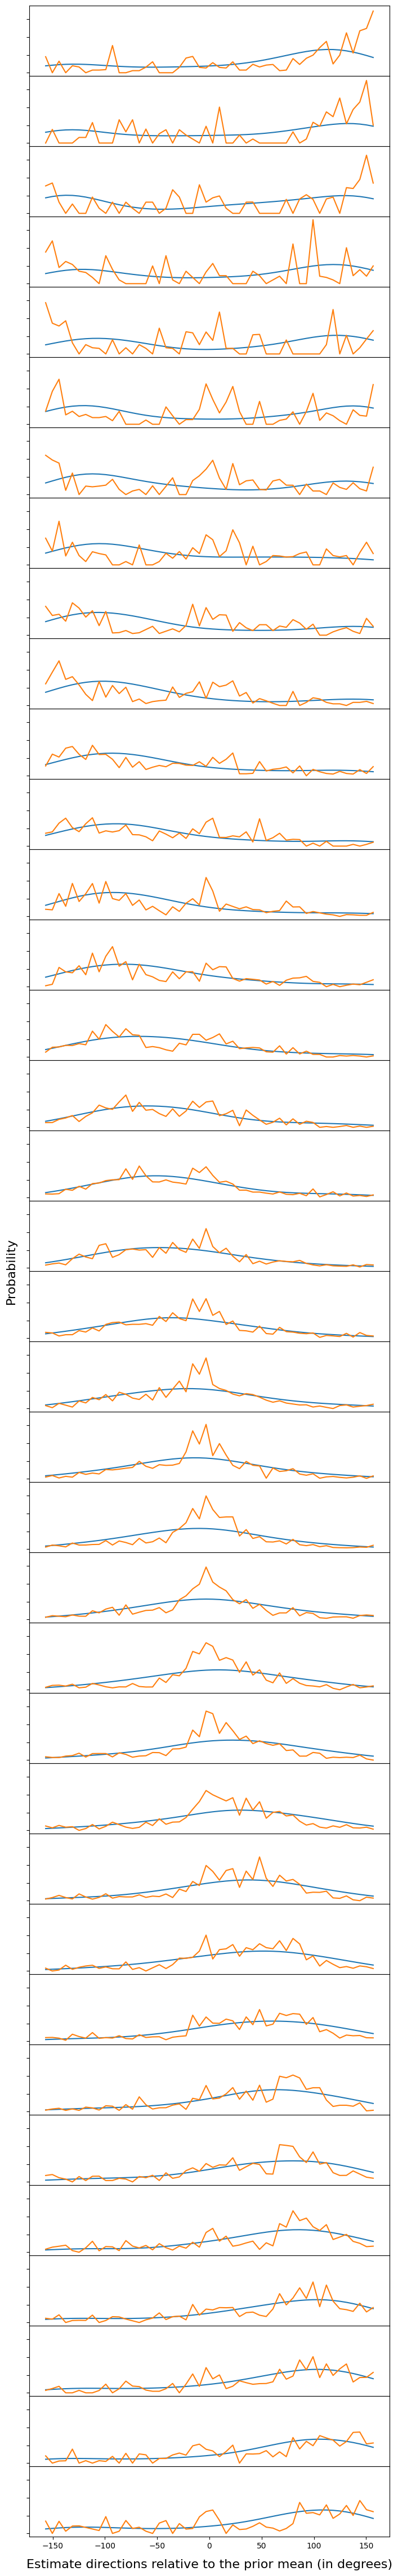

In [316]:
plot_binned_histograms(bin_pairs, noise_kappa=3)

Let's try seeing how the negative log likelihood changes as we vary the different kappa values.


In [341]:
# Subject estimates are averaged over subjects
def generate_bin_pairs_for_kappa_e(data):
    # Split estimated angles into 10 degree bins for a total of 36 bins
    bins = np.linspace(0, 360, 37)
    bin_edges = np.linspace(-160, 160, 51)  # 50 bins, 51 edges

    kappa_prior = 0.05
    kappa_e_values = np.array([0.01, 0.1, 1, 10, 100, 1000])

    data_subset = data[
        [
            "motion_direction",
            "estimates_rad",
            "estimates_deg",
            "motion_coherence",
            "prior_std",
        ]
    ]

    kappa_e_bins = {}
    for kappa_e in kappa_e_values:
        model = BayesianModel(
            kappa_e=kappa_e,
            kappa_prior=kappa_prior,
        )

        negative_log_likelihood = model.neg_log_likelihood(
            [kappa_e, kappa_prior], data_subset
        )

        bin_histograms = []
        for i in range(len(bins) - 1):
            subject_data = data[
                (data["motion_direction"] >= bins[i])
                & (data["motion_direction"] < bins[i + 1])
            ]

            # Generate Bayesian estimates for each motion direction
            estimates = []
            for motion_direction in subject_data["motion_direction"]:
                estimate = model.output(np.deg2rad(motion_direction))
                estimates.append(estimate)

            # Convert estimates to degrees
            estimates_deg = np.rad2deg(estimates)
            estimates_deg = estimates_deg - 225
            estimates_deg = (estimates_deg + 160) % 360 - 160

            bayes_hist, _ = np.histogram(estimates_deg, bins=bin_edges, density=True)
            bayes_hist = np.nan_to_num(bayes_hist)

            # Group by subject and compute histogram for each subject
            all_histograms = []
            grouped = subject_data.groupby("subject_id")
            for subject_id, group in grouped:
                adjusted = group["estimates_deg"]
                adjusted = adjusted - 225
                adjusted = (adjusted + 160) % 360 - 160
                hist, _ = np.histogram(adjusted, bins=bin_edges, density=True)
                hist = np.nan_to_num(hist)
                all_histograms.append(hist)
            subject_est_hist = np.mean(all_histograms, axis=0)

            # bin_histograms.append((smoothed_hist, subject_est_hist))
            bin_histograms.append((bayes_hist, subject_est_hist))

        kappa_e_bins[kappa_e] = (negative_log_likelihood, bin_histograms)

    return kappa_e_bins

In [342]:
def plot_binned_histograms_for_kappa_e(binned_histograms, noise_kappa=1):
    bins = np.linspace(0, 360, 37)
    n_rows = len(bins) - 1
    n_cols = len(binned_histograms)

    # Create a figure with subplots for each column and row
    fig, axs = plt.subplots(
        n_rows,
        n_cols,
        figsize=(8 * n_cols, 50),
        sharex=True,
        sharey=True,
    )

    for col, (key, value) in enumerate(binned_histograms.items()):
        negative_log_likelihood, histograms = value
        for i in range(n_rows):
            ax = axs[i, col]
            bin_edges = np.linspace(-160, 160, 51)  # 50 bins, so 51 edges
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            bayesian_hist = histograms[i][0]
            subject_hist = histograms[i][1]
            motor_noise = vonmises.pdf(np.deg2rad(bin_centers), noise_kappa, loc=0)

            # Perform circular convolution
            smoothed_hist = fftconvolve(bayesian_hist, motor_noise, mode="same")
            smoothed_hist = smoothed_hist / np.trapz(smoothed_hist, bin_centers)

            ax.plot(bin_centers, smoothed_hist, label="Bayesian")
            ax.plot(bin_centers, subject_hist, label="Subject")
            ax.set_yticklabels([])

            # Add column title to the top subplot of each column
            if i == 0:
                ax.set_title(
                    f"Kappa_e: {key}, Neg likelihood: {negative_log_likelihood}",
                    fontsize=14,
                )

            # Add legend to the bottom subplot of each column
            if i == n_rows - 1:
                ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)

    # Add common x and y labels
    fig.text(
        0.5,
        0.01,
        "Estimate directions relative to the prior mean (in degrees)",
        ha="center",
        va="center",
        fontsize=16,
    )
    fig.text(
        0.02,
        0.5,
        "Probability",
        ha="center",
        va="center",
        rotation="vertical",
        fontsize=16,
    )

    # Adjust subplot parameters to reduce the margin
    plt.subplots_adjust(
        left=0.05,  # adjust the left margin
        right=0.95,  # adjust the right margin
        top=0.95,  # adjust the top margin
        bottom=0.05,  # adjust the bottom margin
        wspace=0.2,  # adjust the horizontal space between subplots
        hspace=0.1,  # adjust the vertical space between subplots
    )
    plt.show()

In [343]:
kappa_e_bins = generate_bin_pairs_for_kappa_e(data_subset)

/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/1169249977.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  self.posterior_distribution = unnormalized_posterior / np.trapz(
/Users/kimyoungjin/Desktop/neuromatch/venv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/1639185135.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  smoothed_hist = smoothed_hist / np.trapz(smoothed_hist, bin_centers)
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/1639185135.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  smoothed_hist = smoothed_hist / np.trapz(smoothed_hist, bin_centers)
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/1639185135.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  smoothed_hist = smoothed_hist / np.trapz(smoothed_hist, bin_centers)
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/1639185135.py:27: DeprecationWarning: `trapz` is deprecated. Use `tra

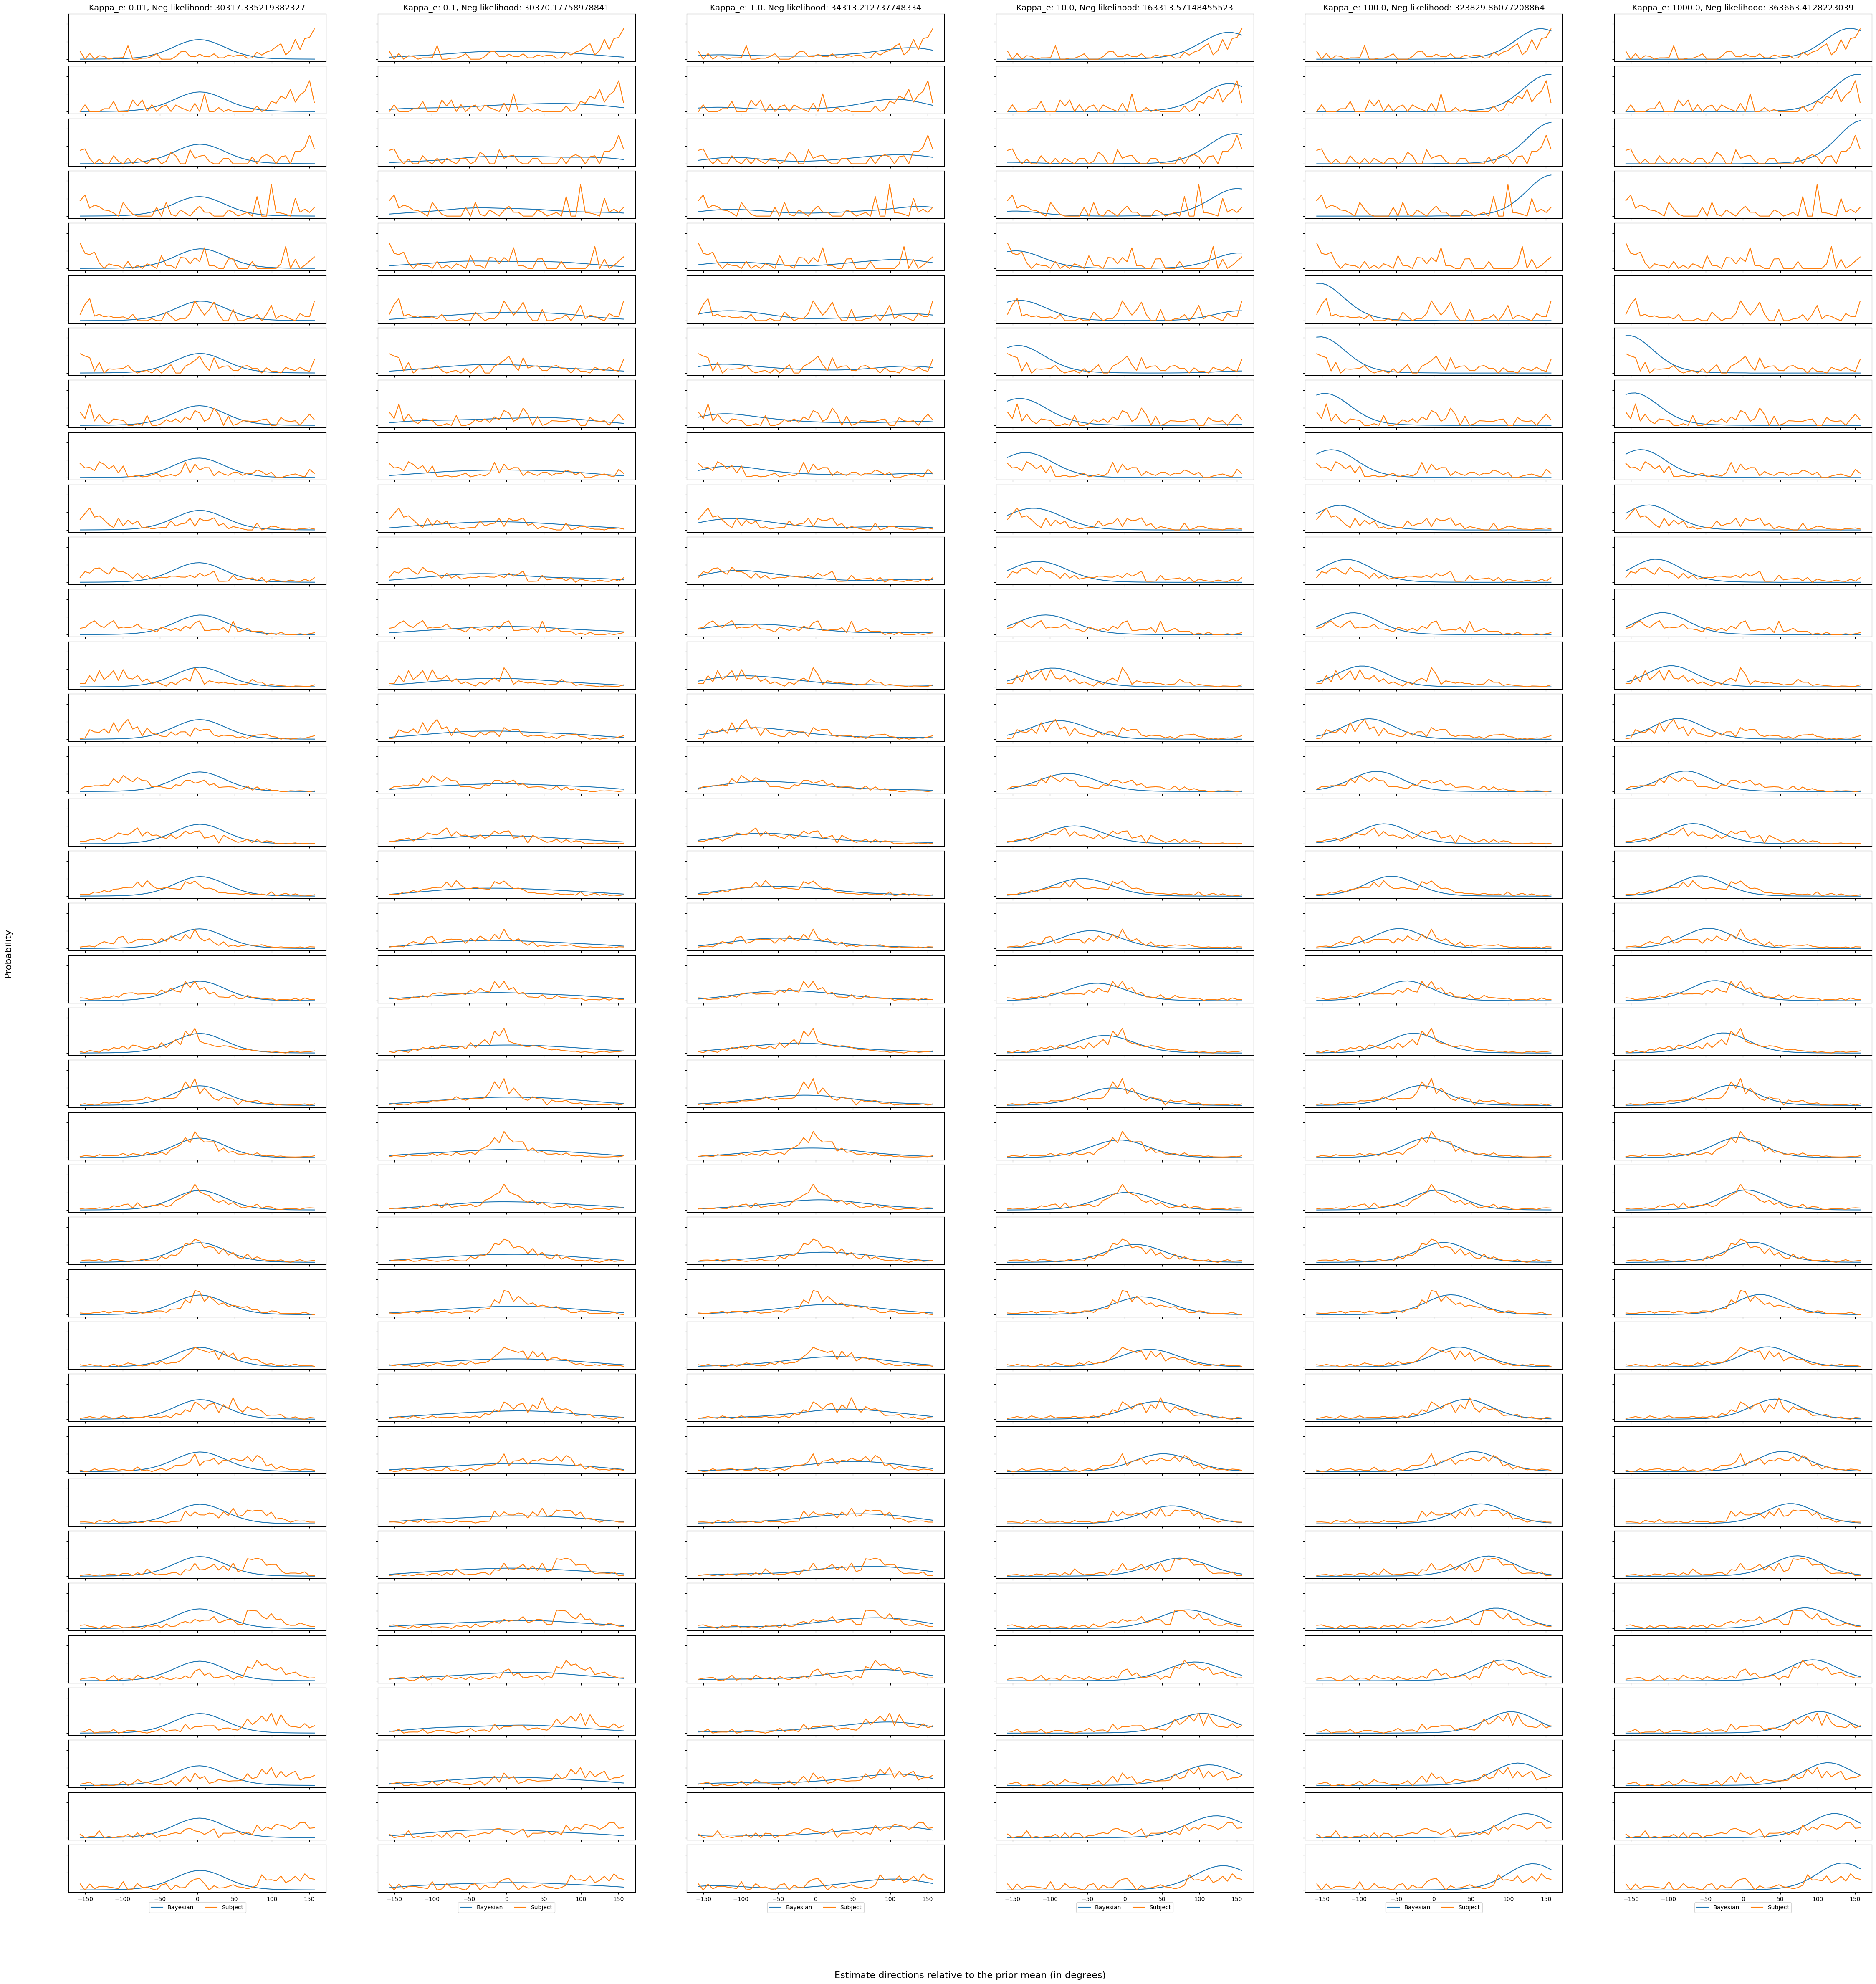

In [344]:
plot_binned_histograms_for_kappa_e(kappa_e_bins, noise_kappa=3)

I guess we can settle on kappa_e 0.1 and kappa_prior 0.05.
Although the log likelihood for kappa_e 0.01 is lower than that for 0.1, its Bayesian estimate distributions just seem to be centered at 225, which seems wrong.


### Get log likelihood calculation for online model

First we will filter all blocks with prior std of 80

And then we iterate through trials in each block, updating our prior distribution estimates.

And then for coherences of 0.06, we pass the current prior distribution (the one we are building up) and also the kappa_e we used for the basic bayesian estimates.

And then we calculate log likelihood.


In [345]:
online_data_subset = data[(data["prior_std"] == 80)]

Let's visualize how the prior distribution is updated as we move across subsequent trials in a run. First, here's the prior distribution from the Basic Bayesian observer:


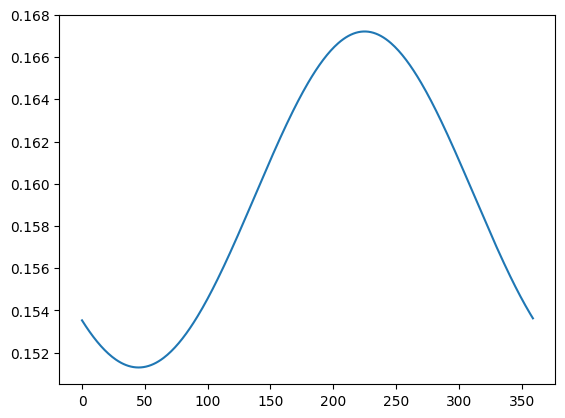

In [375]:
prior_distribution_test = vonmises.pdf(
    model.theta_range, kappa=0.05, loc=np.deg2rad(225)
)
plt.plot(prior_distribution_test)

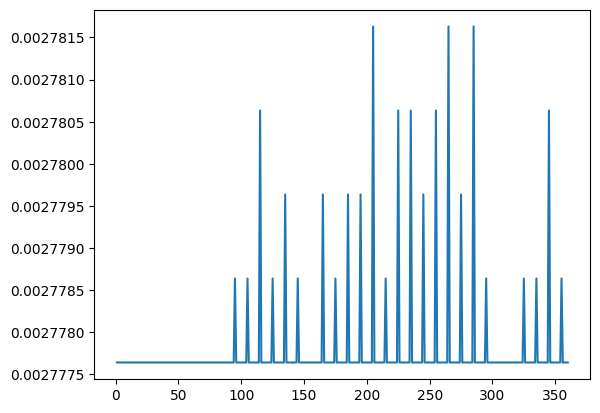

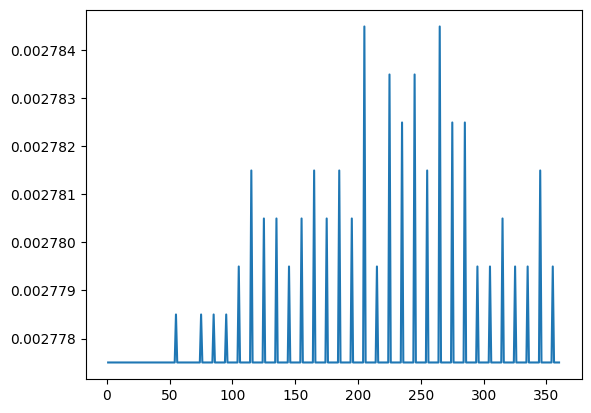

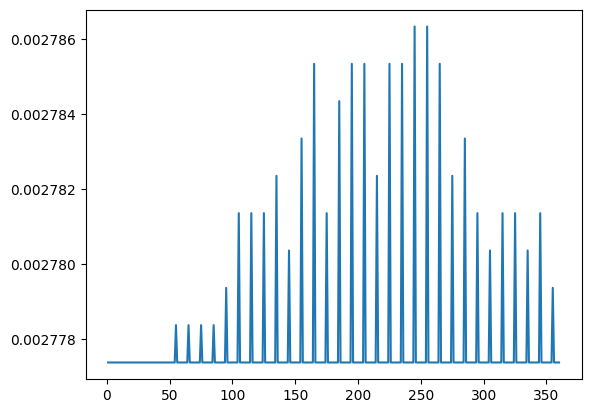

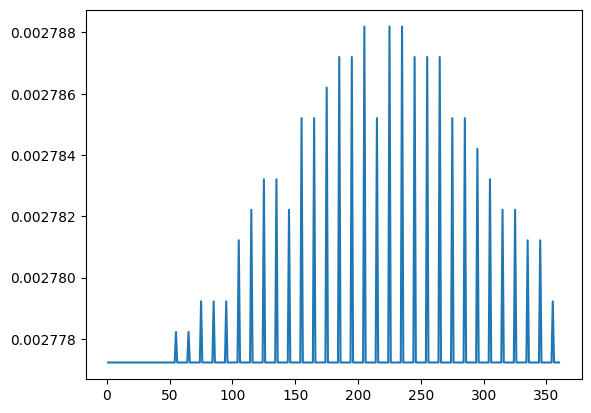

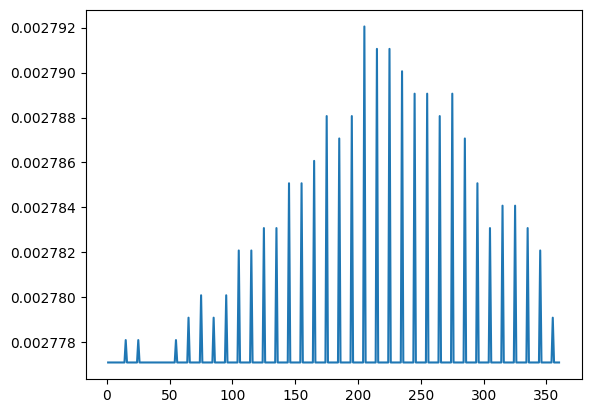

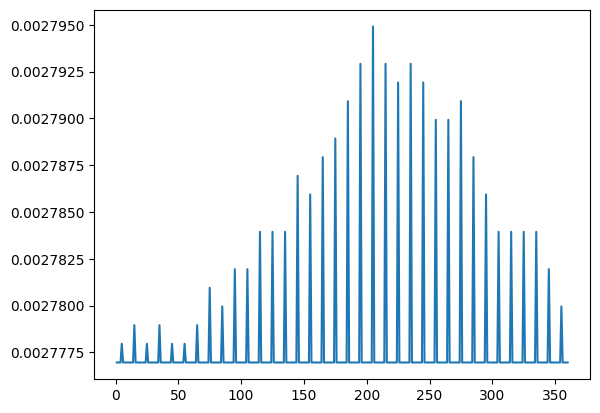

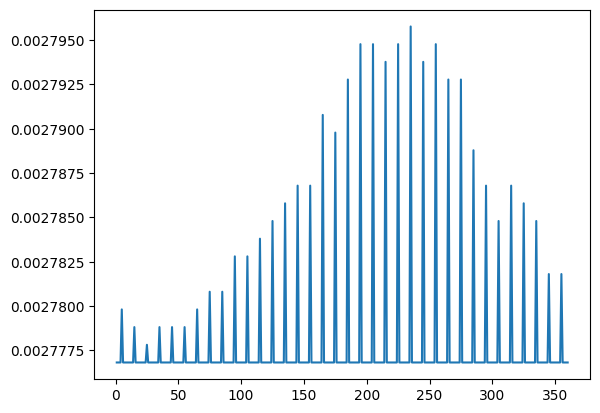

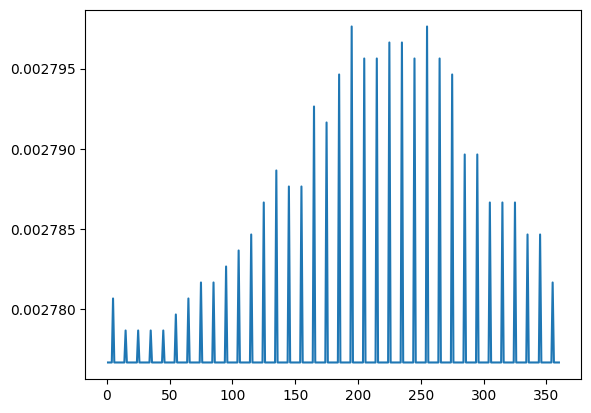

In [386]:
# Group by run_id and loop through groups
learning_rate = 0.000001
run_1 = online_data_subset[online_data_subset["run_id"] == 1]

model = BayesianModel(
    kappa_e=0.1,
    kappa_prior=0.05,
)

x = np.arange(1, 361, 1)

initial_prior = uniform.pdf(x, loc=x[0], scale=x[-1])
initial_prior /= sum(initial_prior)
prior = copy.copy(initial_prior)

# Iterate through trials in each block
for index, row in run_1.iterrows():
    motion_direction = row["motion_direction"]
    theta_est_deg = row["estimates_deg"]
    motion_coherence = row["motion_coherence"]

    # locate the observed state component
    state_loc = np.where(x == int(motion_direction))[0][0]

    # compute its state prediction error
    state_pred_error = learning_rate * (1 - prior[state_loc])

    # use the prediction error to update the state belief
    prior[state_loc] = prior[state_loc] + state_pred_error
    prior /= sum(prior)

    # If we are at the last row in the group, show a plot of the prior
    # with labels indicating the run owe are in

    # Print on every 50th iteration
    if index % 50 == 0:
        plt.plot(x, prior)
        plt.show()

Now we run the online model for ALL runs and calculate the final log likelihood.


In [387]:
# Group by run_id and loop through groups
learning_rate = 0.000001
# learning_rate = 0.00001
# learning_rate = 0.0001
# learning_rate = 0.001
# learning_rate = 0.01
grouped = online_data_subset.groupby("run_id")

model = BayesianModel(
    kappa_e=0.1,
    kappa_prior=0.05,
)

log_prob = 0
for run_id, group in grouped:
    x = np.arange(1, 361, 1)

    initial_prior = uniform.pdf(x, loc=x[0], scale=x[-1])
    initial_prior /= sum(initial_prior)
    prior = copy.copy(initial_prior)

    # Iterate through trials in each block
    for index, row in group.iterrows():
        motion_direction = row["motion_direction"]
        theta_est_deg = row["estimates_deg"]
        motion_coherence = row["motion_coherence"]

        # locate the observed state component
        state_loc = np.where(x == int(motion_direction))[0][0]

        # compute its state prediction error
        state_pred_error = learning_rate * (1 - prior[state_loc])

        # use the prediction error to update the state belief
        prior[state_loc] = prior[state_loc] + state_pred_error
        prior /= sum(prior)

        # If we are at the last row in the group, show a plot of the prior
        # with labels indicating the run owe are in
        # if index == group.index[-1]:
        #     plt.plot(x, prior, label="Run " + str(run_id))
        #     plt.legend()
        #     plt.show()

        # Use the learnt prior to make posterior distribution estimate
        # Only make prediction and update if motion coherence is 0.06
        if motion_coherence == 0.06:
            model_estimate = model.output(motion_direction, prior=prior)
            posterior_distribution = model.posterior_distribution
            log_prob += np.log(posterior_distribution[int(theta_est_deg) - 1] + 1e-10)

print(f"Final log likelihood: {-log_prob}")

/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/623741475.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  self.posterior_distribution = unnormalized_posterior / np.trapz(


Final log likelihood: 30612.817126570135


In [388]:
model = BayesianModel(
    kappa_e=0.1,
    kappa_prior=0.05,
)
data_subset_subset = data_subset[
    [
        "motion_direction",
        "estimates_rad",
        "estimates_deg",
        "motion_coherence",
        "prior_std",
    ]
]
model.neg_log_likelihood([0.1, 0.05], data_subset_subset)

/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_2266/623741475.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  self.posterior_distribution = unnormalized_posterior / np.trapz(


np.float64(30346.292047873663)

We see that Basic Bayesian still beats out the online model by a very small amount.
